In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
# Read data
df = pd.read_csv("CUMPLIMENTADA_REAL.csv")

In [3]:
df.head()

FANALITI  CODEMPRE  CODCENTR  CODDIVIS  CUMPLIMENTADA
0  01SEP2015         1         1         2        4949.79
1  01SEP2015         1         1         4         970.05
2  01SEP2015         1         1         5        3935.90
3  01SEP2015         1         1         6        1045.13
4  01SEP2015         1         1         7        1367.91

In [4]:
df.columns

Index(['FANALITI', 'CODEMPRE', 'CODCENTR', 'CODDIVIS', 'CUMPLIMENTADA'], dtype='object')

In [5]:
df.shape

(1552099, 5)

In [6]:
# Select centro and division
data = df[df['CODEMPRE']==1]
data = data[data['CODCENTR']==1]
data = data[data['CODDIVIS']==16]

In [7]:
data.shape

(874, 5)

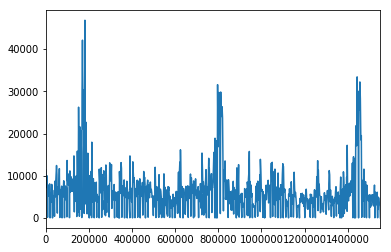

In [8]:
# Pot time series
data['CUMPLIMENTADA'].plot()
plt.show()

In [9]:
# Create serie
day = [string[0:2] for string in data['FANALITI']]
mon = [string[2:5] for string in data['FANALITI']]
dict_mon = {'JAN': '01', 'FEB': '02', 'MAR': '03', 'APR': '04', 'MAY': '05', 'JUN': '06', 
            'JUL': '07', 'AUG': '08', 'SEP': '09', 'OCT': '10', 'NOV': '11', 'DEC': '12'}
month = [dict_mon[m] for m in mon]
year = [string[5:9] for string in data['FANALITI']]
dftime = pd.DataFrame({'year': year,
                       'month': month,
                       'day': day})
dftime = pd.to_datetime(dftime)
idx = pd.date_range(dftime.min(), dftime.max())
s = pd.Series(data=data['CUMPLIMENTADA'].values, index=dftime.dt.strftime('%Y-%m-%d').values)
s.index = pd.DatetimeIndex(s.index)
s = s.reindex(idx, fill_value=0)
dataset = s.values
dataset = dataset.reshape(len(dataset), 1)
dataset = dataset.astype('float32')

In [12]:
# fix random seed for reproducibility
np.random.seed(44)

In [14]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [15]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [16]:
# reshape into X=t and Y=t+1
look_back = 7
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [17]:
# add intervenciones
inter = pd.read_csv("INTERVENCIONES.csv")

day = [string[0:2] for string in inter['fecha']]
month = [string[3:5] for string in inter['fecha']]
year = [string[6:10] for string in inter['fecha']]
intertime = pd.DataFrame({'year': year, 'month': month, 'day': day})
intertime = pd.to_datetime(intertime)
a = intertime[intertime == dftime.min()].index[0]
b = intertime[intertime == dftime.max()].index[0] + 1
inter = inter.iloc[a:b]
inter['year'] = intertime.dt.year[a:b]
inter['month'] = intertime.dt.month[a:b]
inter['day'] = intertime.dt.day[a:b]
inter['week'] = intertime.dt.week[a:b]
inter['weekday'] = intertime.dt.weekday[a:b]
inter['dayofyear'] = intertime.dt.dayofyear[a:b]
inter['quarter'] = intertime.dt.quarter[a:b]
inter = inter.drop(['fecha', 'tipo'], axis = 1)
inter = inter.values
scaler_inter = MinMaxScaler(feature_range=(0, 1))
inter = scaler_inter.fit_transform(inter)
inter_train, inter_test = inter[look_back+1:train_size,:], inter[train_size+look_back+1:len(dataset),:]
trainX = np.concatenate((trainX, inter_train), axis=1)
testX = np.concatenate((testX, inter_test), axis=1)

C:\Users\jaume.puigbo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [18]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [19]:
# create model
model = Sequential()
model.add(LSTM(256, input_shape=(1, look_back+inter.shape[1])))
model.add(Dense(1))
#Compile
model.compile(loss='mae', optimizer='adam')
print(model.summary())
# fit the model
stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=0, mode='auto')
history = model.fit(trainX, trainY, epochs=1000, batch_size=10, validation_data=(testX, testY), callbacks=[stop], verbose=1)
#history = model.fit(trainX, trainY, epochs=1000, batch_size=10, validation_data=(testX, testY), verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               281600    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 281,857
Trainable params: 281,857
Non-trainable params: 0
_________________________________________________________________
None
Train on 591 samples, validate on 288 samples
Epoch 1/1000
591/591 [==============================] - 1s 2ms/step - loss: 0.0739 - val_loss: 0.0654
Epoch 2/1000
591/591 [==============================] - 1s 1ms/step - loss: 0.0684 - val_loss: 0.0594
Epoch 3/1000
591/591 [==============================] - 1s 1ms/step - loss: 0.0656 - val_loss: 0.0622
Epoch 4/1000
591/591 [==============================] - 1s 1ms/step - loss: 0.0670 - val_loss: 0.0615
Epoch 5/1000
591/591 [==============================] - 1s 1ms/step - los

Epoch 74/1000
591/591 [==============================] - 1s 1ms/step - loss: 0.0542 - val_loss: 0.0523
Epoch 75/1000
591/591 [==============================] - 1s 1ms/step - loss: 0.0541 - val_loss: 0.0551
Epoch 76/1000
591/591 [==============================] - 1s 1ms/step - loss: 0.0537 - val_loss: 0.0523
Epoch 77/1000
591/591 [==============================] - 1s 1ms/step - loss: 0.0538 - val_loss: 0.0528
Epoch 78/1000
591/591 [==============================] - 1s 1ms/step - loss: 0.0541 - val_loss: 0.0520
Epoch 79/1000
591/591 [==============================] - 1s 1ms/step - loss: 0.0542 - val_loss: 0.0519
Epoch 80/1000
591/591 [==============================] - 1s 1ms/step - loss: 0.0541 - val_loss: 0.0520
Epoch 81/1000
591/591 [==============================] - 1s 1ms/step - loss: 0.0539 - val_loss: 0.0522
Epoch 82/1000
591/591 [==============================] - 1s 1ms/step - loss: 0.0548 - val_loss: 0.0522
Epoch 83/1000
591/591 [==============================] - 1s 1ms/step - lo

Epoch 153/1000
591/591 [==============================] - 1s 1ms/step - loss: 0.0482 - val_loss: 0.0508
Epoch 154/1000
591/591 [==============================] - 1s 1ms/step - loss: 0.0488 - val_loss: 0.0506
Epoch 155/1000
591/591 [==============================] - 1s 1ms/step - loss: 0.0479 - val_loss: 0.0511
Epoch 156/1000
591/591 [==============================] - 1s 1ms/step - loss: 0.0490 - val_loss: 0.0517
Epoch 157/1000
591/591 [==============================] - 1s 1ms/step - loss: 0.0484 - val_loss: 0.0506
Epoch 158/1000
591/591 [==============================] - 1s 1ms/step - loss: 0.0481 - val_loss: 0.0505
Epoch 159/1000
591/591 [==============================] - 1s 1ms/step - loss: 0.0482 - val_loss: 0.0502
Epoch 160/1000
591/591 [==============================] - 1s 1ms/step - loss: 0.0488 - val_loss: 0.0514
Epoch 161/1000
591/591 [==============================] - 1s 1ms/step - loss: 0.0487 - val_loss: 0.0527
Epoch 162/1000
591/591 [==============================] - 1s 1ms

Epoch 232/1000
591/591 [==============================] - 1s 1ms/step - loss: 0.0441 - val_loss: 0.0476
Epoch 233/1000
591/591 [==============================] - 1s 1ms/step - loss: 0.0436 - val_loss: 0.0480
Epoch 234/1000
591/591 [==============================] - 1s 1ms/step - loss: 0.0437 - val_loss: 0.0492
Epoch 235/1000
591/591 [==============================] - 1s 1ms/step - loss: 0.0436 - val_loss: 0.0481
Epoch 236/1000
591/591 [==============================] - 1s 1ms/step - loss: 0.0442 - val_loss: 0.0483
Epoch 237/1000
591/591 [==============================] - 1s 1ms/step - loss: 0.0434 - val_loss: 0.0481
Epoch 238/1000
591/591 [==============================] - 1s 1ms/step - loss: 0.0432 - val_loss: 0.0482
Epoch 239/1000
591/591 [==============================] - 1s 1ms/step - loss: 0.0435 - val_loss: 0.0481
Epoch 240/1000
591/591 [==============================] - 1s 1ms/step - loss: 0.0436 - val_loss: 0.0487
Epoch 241/1000
591/591 [==============================] - 1s 1ms

Epoch 311/1000
591/591 [==============================] - 1s 1ms/step - loss: 0.0414 - val_loss: 0.0470
Epoch 312/1000
591/591 [==============================] - 1s 1ms/step - loss: 0.0395 - val_loss: 0.0470
Epoch 313/1000
591/591 [==============================] - 1s 1ms/step - loss: 0.0395 - val_loss: 0.0470
Epoch 314/1000
591/591 [==============================] - 1s 1ms/step - loss: 0.0392 - val_loss: 0.0468
Epoch 315/1000
591/591 [==============================] - 1s 1ms/step - loss: 0.0387 - val_loss: 0.0482
Epoch 316/1000
591/591 [==============================] - 1s 1ms/step - loss: 0.0391 - val_loss: 0.0472
Epoch 317/1000
591/591 [==============================] - 1s 1ms/step - loss: 0.0384 - val_loss: 0.0475
Epoch 318/1000
591/591 [==============================] - 1s 1ms/step - loss: 0.0394 - val_loss: 0.0481
Epoch 319/1000
591/591 [==============================] - 1s 1ms/step - loss: 0.0393 - val_loss: 0.0464
Epoch 320/1000
591/591 [==============================] - 1s 1ms

Epoch 390/1000
591/591 [==============================] - 1s 1ms/step - loss: 0.0360 - val_loss: 0.0474
Epoch 391/1000
591/591 [==============================] - 1s 1ms/step - loss: 0.0352 - val_loss: 0.0476
Epoch 392/1000
591/591 [==============================] - 1s 1ms/step - loss: 0.0348 - val_loss: 0.0471
Epoch 393/1000
591/591 [==============================] - 1s 1ms/step - loss: 0.0351 - val_loss: 0.0477
Epoch 394/1000
591/591 [==============================] - 1s 1ms/step - loss: 0.0349 - val_loss: 0.0478
Epoch 395/1000
591/591 [==============================] - 1s 1ms/step - loss: 0.0349 - val_loss: 0.0468
Epoch 396/1000
591/591 [==============================] - 1s 1ms/step - loss: 0.0382 - val_loss: 0.0492
Epoch 397/1000
591/591 [==============================] - 1s 1ms/step - loss: 0.0354 - val_loss: 0.0488
Epoch 398/1000
591/591 [==============================] - 1s 1ms/step - loss: 0.0357 - val_loss: 0.0470
Epoch 399/1000
591/591 [==============================] - 1s 1ms

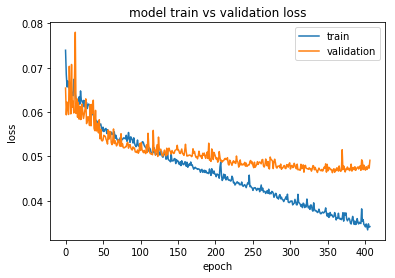

In [20]:
# Loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [21]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# calculate root mean squared error
trainScore = mean_absolute_error(trainY[0], trainPredict[:,0])
print('Train Score: %.2f MAE' % (trainScore))
testScore = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.2f MAE' % (testScore))

Train Score: 2821.72 RMSE
Test Score: 3463.43 RMSE
Train Score: 1664.66 MAE
Test Score: 2299.85 MAE


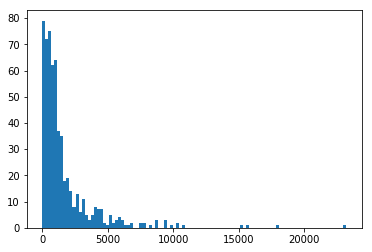

In [22]:
# Distribution test error
plt.hist(np.abs(trainY[0] - trainPredict[:,0]), bins=100)
plt.show()

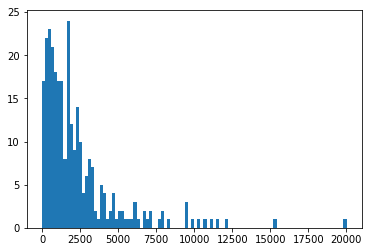

In [23]:
# Distribution test error
plt.hist(np.abs(testY[0] - testPredict[:,0]), bins=100)
plt.show()

In [24]:
# MAE data < quantile 99
diff = np.abs(testY[0] - testPredict[:,0])
q = np.percentile(diff, 99)
np.mean(diff[diff<q])

2157.944833008602

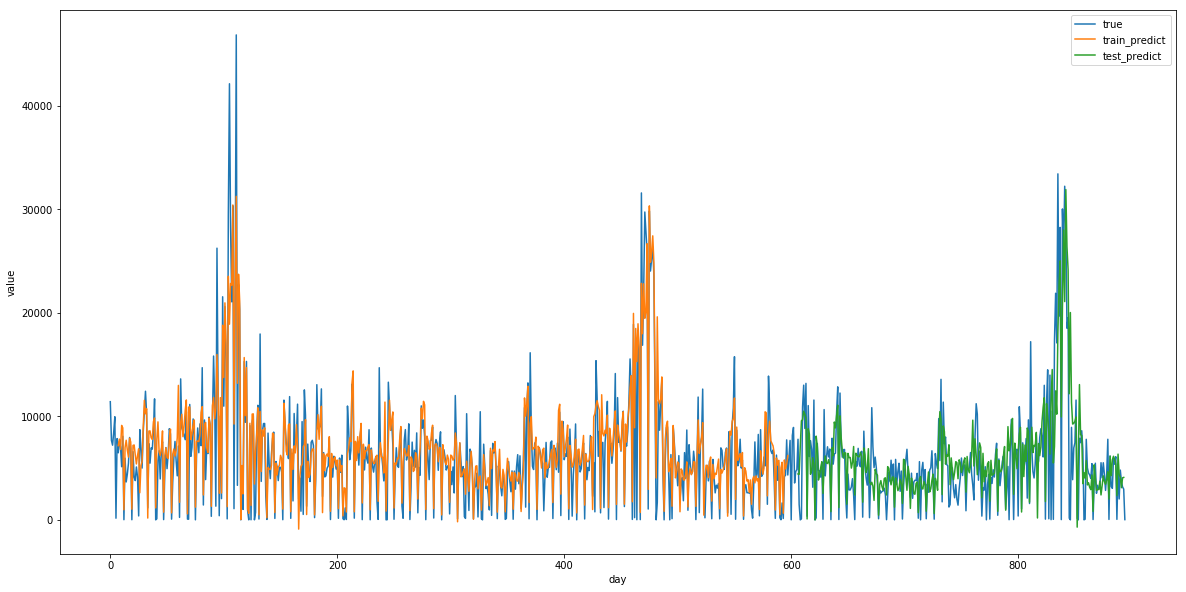

In [25]:
# shift train predictions for plotting
plt.figure(figsize=(20,10))
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot true and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.ylabel('value')
plt.xlabel('day')
plt.legend(['true', 'train_predict', 'test_predict'], loc='upper right')
plt.show()

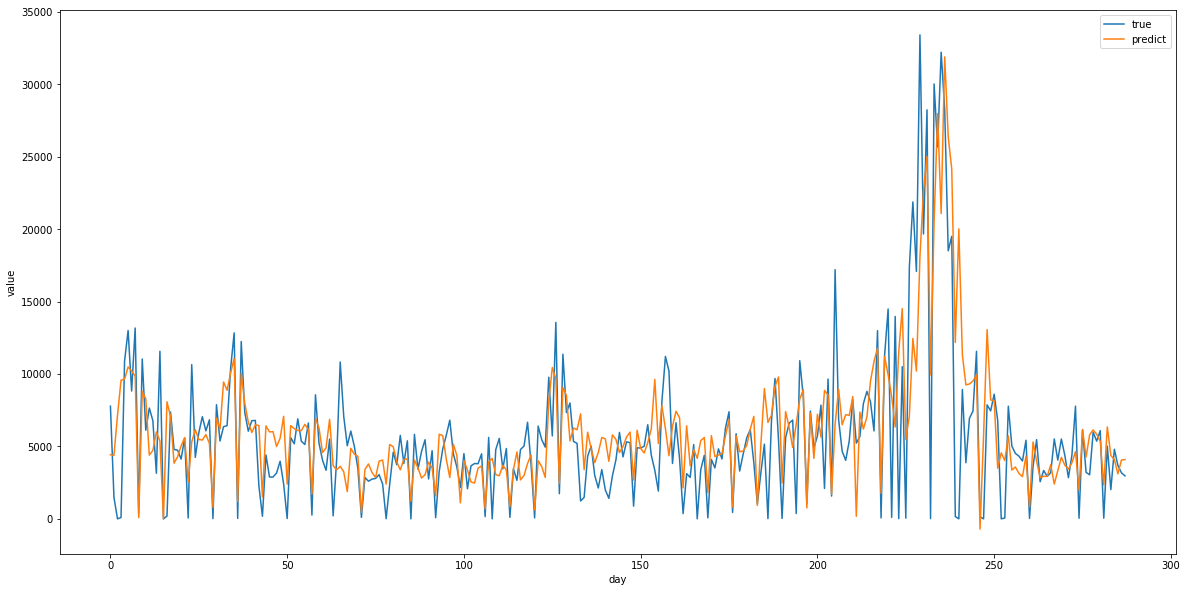

In [26]:
# plot test
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(dataset)[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :])
plt.plot(testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :])
plt.ylabel('value')
plt.xlabel('day')
plt.legend(['true', 'predict'], loc='upper right')
plt.show()

In [27]:
# MAE median model
media = np.mean(scaler.inverse_transform(dataset)[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :])
diff = np.abs(testY[0] - media)
np.mean(diff)

3263.2108547427601

In [28]:
# Output
output = pd.DataFrame({'date': s.index[len(trainPredict)+(look_back*2)+1:len(dataset)-1], 
                       'true': scaler.inverse_transform(dataset)[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :].ravel(), 
                       'pred': testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :].ravel()})

In [29]:
output.to_csv("ouput_1_1_16_con_intervención_addTimeData.csv", index=False)